# NEURAL APPEARNACE ESTIMATION

### UTILS

In [59]:
import torch
import numpy as np
from PIL import Image
from io import BytesIO

import torchvision.transforms as transforms
from IPython.display import display, Image as IPImage

def z_scoring(x_rep, thresh=1.5):
    pr_rep = torch.norm(x_rep, dim=1)
    pr_min, pr_max = pr_rep.min(), pr_rep.max()
    pr_rep = (pr_rep - pr_min) / (pr_max - pr_min)
    mean = pr_rep.mean((1, 2))  
    std = torch.std(pr_rep)
    z_scores = (pr_rep - mean[:,None,None]) / std
    outliers = z_scores > thresh
    return outliers

to_pil = transforms.ToPILImage()
def display_linear_image(tensor):
    disp_tensor = tensor# ** (1.0 / 2.2)
    disp_tensor = torch.nan_to_num(torch.clamp(disp_tensor, 0.0, 1.0), 0.0)
    image = to_pil(disp_tensor.squeeze())
    display(image)

def display_neural_material(neural_mat):
    neural_mat_norm = torch.norm(neural_mat.squeeze(), p=2, dim=0, keepdim=True).repeat(3, 1, 1)
    filted_features = neural_mat_norm * torch.logical_not(z_scoring(neural_mat, thresh=2.0))[None]
    pr_min, pr_max = filted_features.min(), filted_features.max()
    pr_rep = torch.clamp((neural_mat_norm - pr_min) / (pr_max - pr_min), 0.0, 1.0)
    
    image = to_pil(pr_rep)
    display(image)

def display_video(video_tensor):
    video_tensor = torch.clamp(torch.nan_to_num(video_tensor, 0.0), 0.0, 1.0)
    video_np = video_tensor.cpu().numpy()
    
    frames = []
    for frame in video_np:
        frame_display = np.transpose(frame, (1, 2, 0))
        frames.append(frame_display)

    with BytesIO() as gif:
        frames[0] = Image.fromarray((frames[0] * 255).astype(np.uint8))
        frames[0].save(gif, format='gif', save_all=True, append_images=[Image.fromarray((frame * 255).astype(np.uint8)) for frame in frames[1:]], loop=0)
        gif.seek(0)
        display(IPImage(data=gif.getvalue(), format='gif'))


### GET DEVICE

In [60]:
if torch.cuda.is_available():
    m_device = torch.device("cuda:1")
else:
    m_device = torch.device("cpu")
print("Using device:", m_device)

Using device: cuda:1


### LOAD IMAGE

['blue-metal-tiped-mush.png', 'bluish-tiles-with-copper.png', 'brass-pot-lid.png', 'close-granite-tiles-with-copper.png', 'complex-camera-face.png', 'copper-rough-bricks.png', 'dark-mush.png', 'dark-rough-bricks-square-bumps.png', 'dark-square-bumps.png', 'dark-tiles-with-copper.png', 'double-red-brick.png', 'eggshell-plastic-bubbles.png', 'fancy-wood-pattern.png', 'fine-square-bumps.png', 'fine-watch-face.png', 'gold-star-inlay.png', 'granite-faint-tiles-with-copper.png', 'granite-tiles-with-copper.png', 'green-carbon-fiber.png', 'grey-mush.png', 'grey-plastic-waves.png', 'grey-rough-bricks-square-bumps.png', 'halfway-copper.png', 'large-teal-waves.png', 'long-thin-planks.png', 'marble-rough-bricks.png', 'marble-square-bumps.png', 'metal-framed-rectangles.png', 'metal-t-junction.png', 'mossy-stone-bricks.png', 'nailed-tiles.png', 'old-treasure-chest.png', 'peeling-blue-paint.png', 'red-carbon-fiber.png', 'redish-mush.png', 'redish-tiles-with-copper.png', 'red-plastic-diamonds.png', 'r

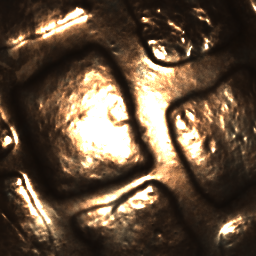

In [61]:
import os
from brdf_utils import loadImage, load_exr
# TODO: pick a few good ones
input_photo_dir = "demo_images"
input_photo_names = [fn for fn in os.listdir(input_photo_dir)]# if '.png' in fn.lower()]
print(input_photo_names)

photo_id = 5

input_photo = loadImage(os.path.join(input_photo_dir, input_photo_names[photo_id]))
input_photo = input_photo.unsqueeze(0).to(m_device)
input_photo = input_photo #** 2.2 # already in linear color-space
in_height, in_width = input_photo.shape[-2:]
display_linear_image(input_photo.cpu())

### LOAD MODEL

In [42]:
def get_num_parameters(model):
    num_params = sum(p.numel() for p in model.parameters())
    return num_params
    
from models.prl_net import RelitPixelNet
from models.prl_feature_injector import SineDirectionEncoder_NN
from models.prl_resnet import GenResNetReplicateHA
from models.prl_pixel_mlp import *
model_path = "model_data/LDR_B3_256_best.pth" # "model_data/ldr_final_model.pth"
model : RelitPixelNet = torch.load(model_path).to(m_device)
model = model.eval()

m_est : GenResNetReplicateHA = model.resnet
m_render : NaiveMLPRenderer = model.render_net
out_direction_encoder : SineDirectionEncoder_NN = model.render_encoder
print(type(model.space_manager.compress_input))

print(f"M_est has {get_num_parameters(m_est)} parameters.")
print(f"M_render has {get_num_parameters(m_render)} parameters.")
print(f"The positional encoder, ND_enc, {get_num_parameters(out_direction_encoder)} parameters.")

<class 'models.prl_pixel_mlp.ClampedLogMod'>
M_est has 84008960 parameters.
M_render has 86208 parameters.
The positional encoder, ND_enc, 548262 parameters.


### CREATE NEURAL MATERIAL PARAMETERS

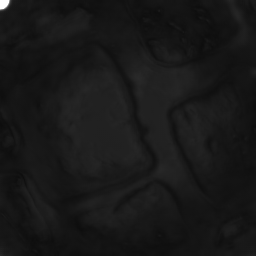

In [47]:
from brdf_render import generateDirectionMaps
with torch.no_grad():
    model = model.eval().to(m_device)
    view_position = torch.tensor([[0.0, 0.0, 4.0]], device=m_device) # 4.0 ≈ 1.0 / tan((28 / 2) degrees); for an FOV of 28 degrees
    light_position = view_position # colocated light and view for input

    # Convert light and view positions to normalized direction vectors for each pixel of the input
    light_dirs, view_dirs = generateDirectionMaps(light_position, view_position, in_height)

    # Make the neural material parameters, function handles log-relative mapping
    neural_mat = model.make_neural_feature_rep(input_photo.to(m_device), light_dirs, view_dirs)
    display_neural_material(neural_mat.clone().cpu())

### GENERATE RE-RENDERS WITH THE NEURAL MATERIAL MAP

Displaying:


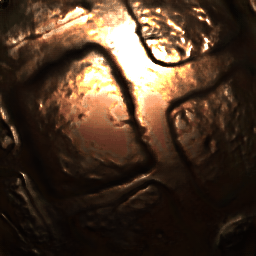

In [51]:
with torch.no_grad():
    model = model.eval().to(m_device)
    # MAKE LIGHT POSITIONS IN A CIRCLE ABOVE THE MATERIAL
    k = 32 # number of samples
    radius = 1.0 # radius of light
    light_height = 3.0
    light_height = torch.tensor([[light_height]] * k, device=m_device)
    angles = ((torch.arange(0, k, dtype=torch.float, device=m_device) / k) * torch.pi * 2)[:,None]
    light_position = torch.cat([torch.sin(angles) * radius, torch.cos(angles) * radius, light_height], dim=1)
    view_position = torch.tensor([[0.0, 0.0, 4.0]] * k, device=m_device)

    # MAKE DIRECTIONS
    lt, vt = generateDirectionMaps(light_position, view_position, in_height)

    # RENDER
    log_rerender = model.render_from_neural_rep_multi(neural_mat, lt, vt).squeeze()
    circle_renders = model.space_manager.decompress_target_call(log_rerender)

    # DISPLAY
    print("Rendering Done. Displaying:")
    display_video((circle_renders.squeeze()).cpu())


### IDENTITY

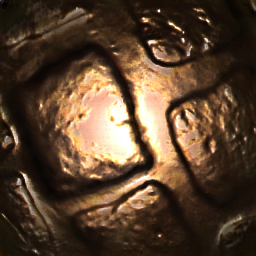

In [53]:
with torch.no_grad():
    model = model.eval().to(m_device)
    lv = torch.tensor([[0.0, 0.0, 4.0]], device=m_device)
    lt, vt = generateDirectionMaps(lv, lv, 256)
    ident_render, _ = model.render_multi(input_photo, lt, vt, lt, vt)
    display_linear_image(ident_render)

